# Event-data Representation and Visualization

The **goals** of this exercise are:
- to familiarize yourself with the data produced by an event-based camera
- to practice converting the event data into image-like (also called "grid-based" or "array-based") representations, which is a common practice of many algorithms (without judging whether it is "optimal" or not).
- to produce "pretty plots" (never underestimate the value of good figures on reports and papers).

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Simple code to read event data
def extract_data(filename):
    infile = open(filename, 'r')
    timestamp = []
    x = []
    y = []
    pol = []
    for line in infile:
        words = line.split()
        timestamp.append(float(words[0]))
        x.append(int(words[1]))
        y.append(int(words[2]))
        pol.append(int(words[3]))
    infile.close()
    return timestamp,x,y,pol

In [3]:
# Load event data
filename_sub = '../data/slider_depth/events_chunk.txt'
timestamp, x, y, pol = extract_data(filename_sub)
img_size = (180,240)
height, width = img_size
print(f"Loaded {len(timestamp)} events")

Loaded 50000 events


## Task 1: Event Histogram (Balance of Polarities)

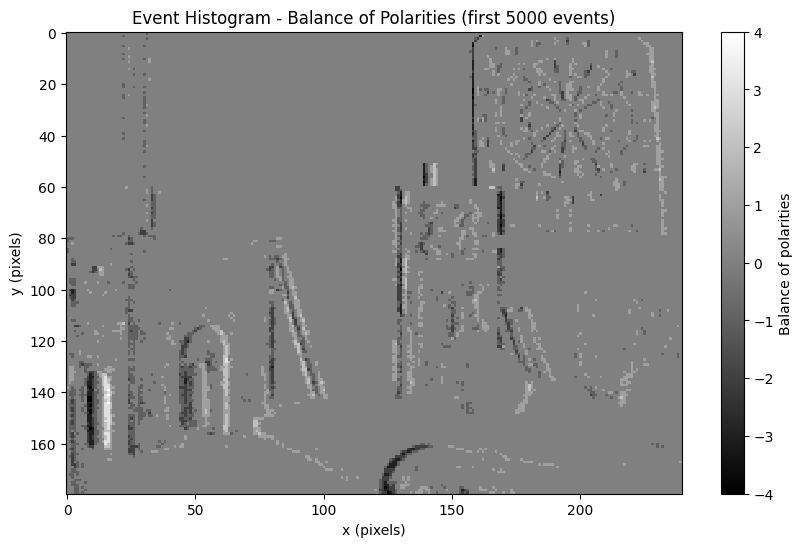

In [4]:
# Create a histogram of events (Event count) - first 5000 events
N_e = 5000

# Initialize histogram array
event_histogram = np.zeros((height, width), dtype=int)

# Accumulate events pixel-wise with polarities
for i in range(min(N_e, len(x))):
    pixel_x = x[i]
    pixel_y = y[i]
    polarity = pol[i]
    
    # Convert polarity: 1 -> +1, 0 -> -1
    polarity_value = 1 if polarity == 1 else -1
    event_histogram[pixel_y, pixel_x] += polarity_value

# Plot the histogram as grayscale image
plt.figure(figsize=(10, 6))
plt.imshow(event_histogram, cmap='gray', interpolation='nearest')
plt.colorbar(label='Balance of polarities')
plt.title(f'Event Histogram - Balance of Polarities (first {N_e} events)')
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.show()

# Print statistics for analysis
max_pos = np.max(event_histogram)
min_neg = np.min(event_histogram)

### Questions and Answers

In [5]:
print("Q: What do the 'three colors' in the image represent?")
print("A: The three colors represent:")
print("   - Dark pixels: More negative events (polarity 0) than positive events")
print("   - Gray pixels: Balanced events or no events (zero balance)")
print("   - Bright pixels: More positive events (polarity 1) than negative events")
print("Q: What could such an image be used for?")
print("A: Edge detection, motion analysis, feature extraction, noise filtering, object tracking")

Q: What do the 'three colors' in the image represent?
A: The three colors represent:
   - Dark pixels: More negative events (polarity 0) than positive events
   - Gray pixels: Balanced events or no events (zero balance)
   - Bright pixels: More positive events (polarity 1) than negative events
Q: What could such an image be used for?
A: Edge detection, motion analysis, feature extraction, noise filtering, object tracking


## Task 2: Pseudocolor Visualization

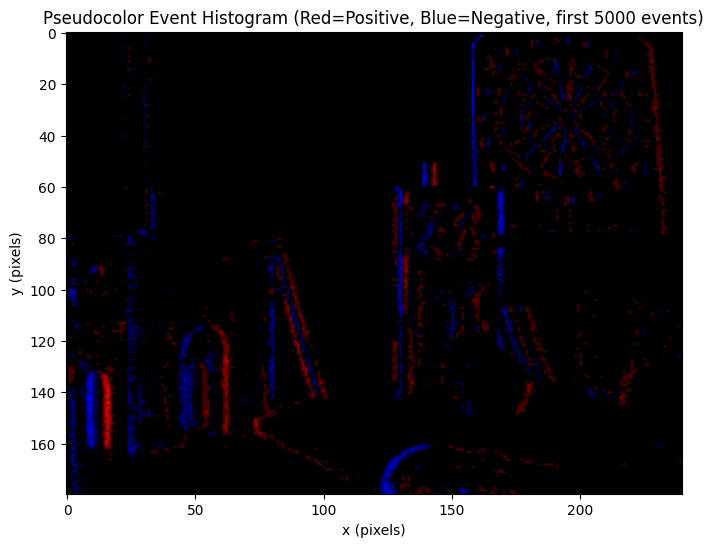

Red=Positive events, Blue=Negative events, White=No events


In [6]:
# Create pseudocolor visualization (red for positive, blue for negative)
plt.figure(figsize=(10, 6))

# Create RGB image
rgb_image = np.zeros((height, width, 3))

# Red channel for positive events, blue channel for negative events
pos_mask = event_histogram > 0
neg_mask = event_histogram < 0

# Normalize for visualization
max_abs = max(abs(np.max(event_histogram)), abs(np.min(event_histogram)))

if max_abs > 0:
    # Red for positive events
    rgb_image[pos_mask, 0] = event_histogram[pos_mask] / max_abs
    # Blue for negative events  
    rgb_image[neg_mask, 2] = -event_histogram[neg_mask] / max_abs

plt.imshow(rgb_image)
plt.title(f'Pseudocolor Event Histogram (Red=Positive, Blue=Negative, first {N_e} events)')
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.show()

print("Red=Positive events, Blue=Negative events, White=No events")

## Task 3: Time Surface with Exponential Decay

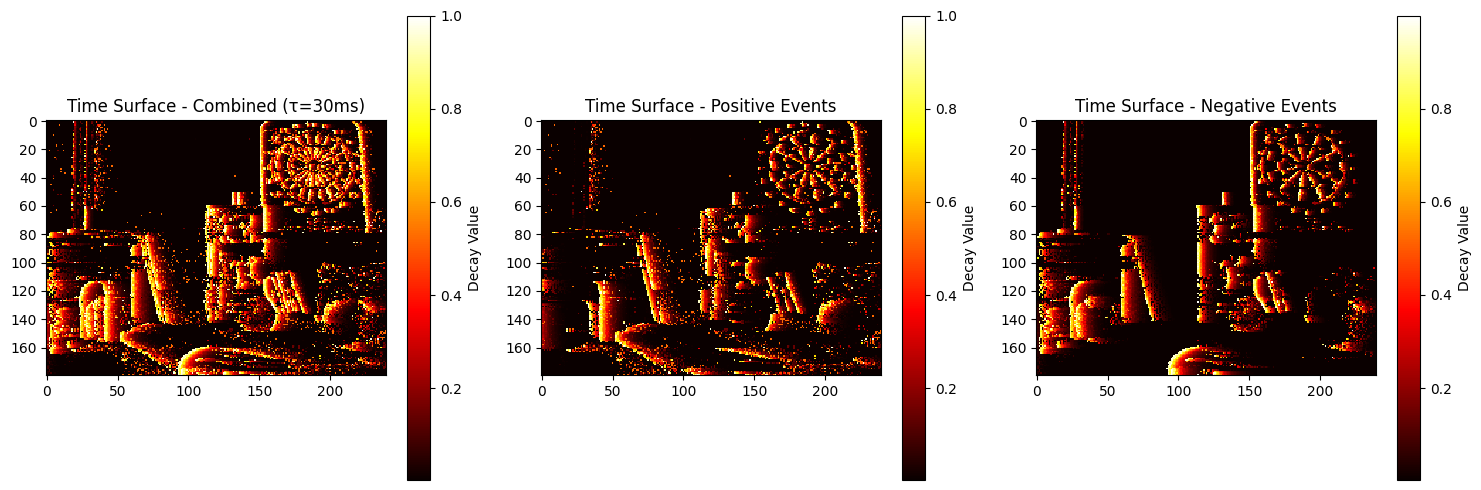

In [7]:
# Time surface with exponential decay implementation
N_e_time = min(50000, len(timestamp))
tau = 0.030  # 30 ms decay constant

# Initialize time surfaces
last_timestamp_combined = np.zeros((height, width))
last_timestamp_pos = np.zeros((height, width))
last_timestamp_neg = np.zeros((height, width))

# Process events
for i in range(N_e_time):
    pixel_x = x[i]  
    pixel_y = y[i]
    polarity = pol[i]
    t = timestamp[i]
    
    # Update combined time surface
    last_timestamp_combined[pixel_y, pixel_x] = t
    
    # Update polarity-specific time surfaces
    if polarity == 1:
        last_timestamp_pos[pixel_y, pixel_x] = t
    else:
        last_timestamp_neg[pixel_y, pixel_x] = t

# Get the last timestamp for reference
t_current = timestamp[N_e_time - 1]

# Compute exponential decay time surfaces
time_surface_combined = np.exp(-np.abs(t_current - last_timestamp_combined) / tau)
time_surface_pos = np.exp(-np.abs(t_current - last_timestamp_pos) / tau)
time_surface_neg = np.exp(-np.abs(t_current - last_timestamp_neg) / tau)

# Plot time surfaces
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(time_surface_combined, cmap='hot', interpolation='nearest')
plt.colorbar(label='Decay Value')
plt.title(f'Time Surface - Combined (τ={tau*1000:.0f}ms)')

plt.subplot(1, 3, 2)
plt.imshow(time_surface_pos, cmap='hot', interpolation='nearest')
plt.colorbar(label='Decay Value')
plt.title(f'Time Surface - Positive Events')

plt.subplot(1, 3, 3)
plt.imshow(time_surface_neg, cmap='hot', interpolation='nearest')
plt.colorbar(label='Decay Value')
plt.title(f'Time Surface - Negative Events')

plt.tight_layout()
plt.show()

## Task 4: 3D Space-Time Visualization

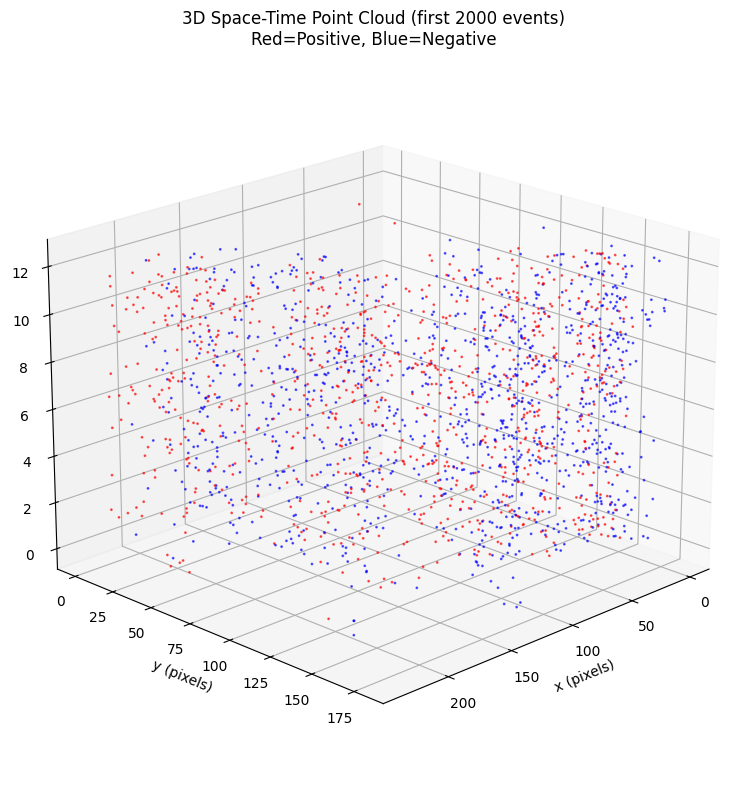

3D visualization reveals spatio-temporal structure of events


In [8]:
# 3D Space-time point cloud visualization
N_e_3d = 2000

# Extract coordinates and polarities for the first N_e_3d events
x_3d = np.array(x[:N_e_3d])
y_3d = np.array(y[:N_e_3d])
t_3d = np.array(timestamp[:N_e_3d])
pol_3d = np.array(pol[:N_e_3d])

# Normalize time for better visualization
t_3d_norm = (t_3d - t_3d[0]) * 1000  # Convert to milliseconds from start

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Color points by polarity: red for positive (1), blue for negative (0)
colors = ['blue' if p == 0 else 'red' for p in pol_3d]

# Create scatter plot
scatter = ax.scatter(x_3d, y_3d, t_3d_norm, c=colors, alpha=0.6, s=1)

# Set labels and title
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
ax.set_zlabel('Time (ms)')
ax.set_title(f'3D Space-Time Point Cloud (first {N_e_3d} events)\nRed=Positive, Blue=Negative')

# Set viewing angle for better visualization
ax.view_init(azim=45, elev=20)

plt.tight_layout()
plt.show()

print("3D visualization reveals spatio-temporal structure of events")

## Task 5: Voxel Grid Representation

In [9]:
# Voxel grid representation implementation
N_e_voxel = min(20000, len(timestamp))
n_time_bins = 5

# Get time range for the events
t_min = timestamp[0]
t_max = timestamp[N_e_voxel - 1]

# Create bins
x_bins = np.arange(0, width + 1)
y_bins = np.arange(0, height + 1) 
t_bins = np.linspace(t_min, t_max, n_time_bins + 1)

# Extract data for histogramming
x_voxel = np.array(x[:N_e_voxel])
y_voxel = np.array(y[:N_e_voxel])
t_voxel = np.array(timestamp[:N_e_voxel])

# Create 3D histogram using numpy
hist_3d, edges = np.histogramdd([x_voxel, y_voxel, t_voxel], bins=[x_bins, y_bins, t_bins])

# Count occupied voxels
occupied_voxels = np.sum(hist_3d > 0)
total_voxels = hist_3d.size
sparsity_ratio = occupied_voxels / total_voxels

print(f"Occupied voxels: {occupied_voxels}")
print(f"Total voxels: {total_voxels}")
print(f"Sparsity ratio: {sparsity_ratio:.4f}")

Occupied voxels: 17251
Total voxels: 216000
Sparsity ratio: 0.0799


## Task 6: Experimental Visualizations

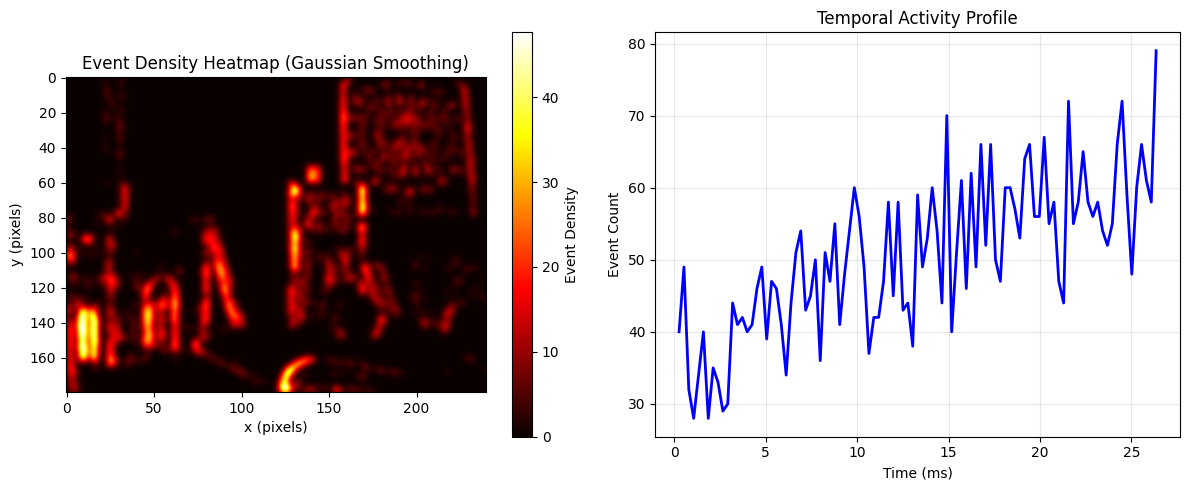

In [10]:
# Experimental visualization: Event density heatmap

density_map = np.zeros((height, width))
gaussian_sigma = 2.0

for i in range(min(N_e, len(x))):
    pixel_x = x[i]
    pixel_y = y[i]
    
    # Add Gaussian blob around each event
    y_range = np.arange(max(0, int(pixel_y - 3*gaussian_sigma)), 
                       min(height, int(pixel_y + 3*gaussian_sigma + 1)))
    x_range = np.arange(max(0, int(pixel_x - 3*gaussian_sigma)), 
                       min(width, int(pixel_x + 3*gaussian_sigma + 1)))
    
    for py in y_range:
        for px in x_range:
            distance_sq = (px - pixel_x)**2 + (py - pixel_y)**2
            weight = np.exp(-distance_sq / (2 * gaussian_sigma**2))
            density_map[py, px] += weight

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(density_map, cmap='hot', interpolation='bilinear')
plt.colorbar(label='Event Density')
plt.title('Event Density Heatmap (Gaussian Smoothing)')
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

# Temporal activity profile
time_bins_profile = np.linspace(timestamp[0], timestamp[min(N_e, len(timestamp))-1], 100)
activity_profile = np.histogram(timestamp[:N_e], bins=time_bins_profile)[0]

plt.subplot(1, 2, 2)
plt.plot((time_bins_profile[1:] - timestamp[0]) * 1000, activity_profile, 'b-', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Event Count')
plt.title('Temporal Activity Profile')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()